# DAML 08 - kmeans

Michal Grochmal <michal.grochmal@city.ac.uk>

The **expectation-maximization** (E-M) algorithm is often useful in machine learning.
It consists of the repetition of E-steps (expectation) and M-steps (maximization) until
the algorithm converges to a point where more steps would not change the solution.
In other words at each step some **fitness function** comes closer to an optimal value.
In general the algorithm looks as follows:

1.  Assign data to the expected solution from previous step (E-step)
2.  Change the solution so that the current state of data maximizes a fitness function (M-step)
3.  Repeat until convergence

The `kmeans` algorithm is a clear implementation of expectation-maximization,
the algorithm works as follows:

1.  Assign random cluster centers
2.  (E-step) assign data points, according to some distance measure, to the closest cluster center
3.  (M-step) create new cluster centers from the mean of currently assigned data points

Note that the above requires some form of **distance measure**, and that the *fitness function*
is the minimization of all the distances.
Let's do the initial imports and dive into `kmeans`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

We will use `sklearn`'s samples generator `make_blobs` to build three clusters of points.
the blobs will be between -10 and 10, and will be preassigned to classes.

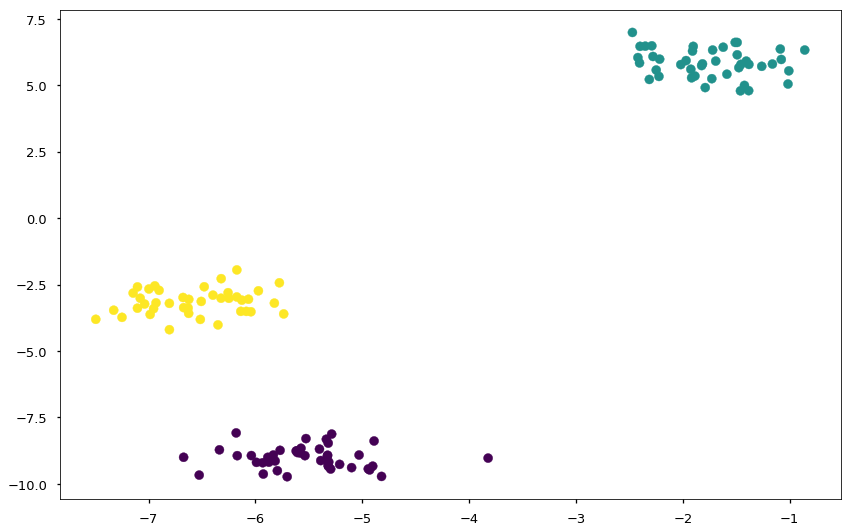

In [2]:
from sklearn.datasets.samples_generator import make_blobs
cluster_num = 3
X, y = make_blobs(n_samples=128, centers=cluster_num, cluster_std=0.5)
fig, ax = plt.subplots(figsize=(14, 9))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis');

Now we can implement an *expectation-maximization* algorithm ourselves.
The following is a very simple implementation of `kmeans`.
We perform the expectation step by first randomly assigning cluster centers,
later the expectation step is performed by taking the mean of the points in the cluster.
The maximization step is performed using `pairwise_distances` to the currently
assigned cluster centers.

We plot the results.
Since `kmeans` has the tendency of choking when a cluster center is not close enough to at least
one point, we may need to run the following several times until a good solution is found.
Note that we use a heuristic about initial cluster location,
we assume that our data is centers on zero and assign cluster centers
within the mean variance of the data from the origin.

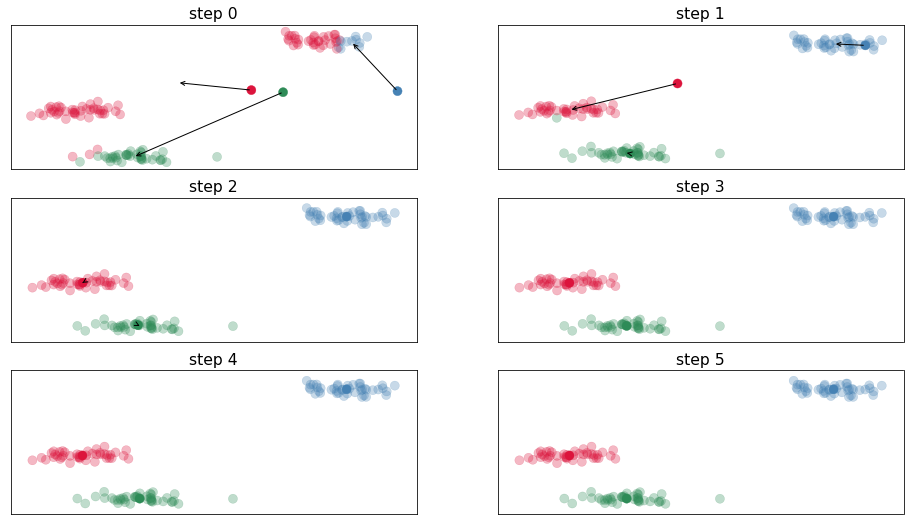

In [3]:
from sklearn.metrics import pairwise_distances
steps = 6
clusters = np.random.rand(3, 2)*X.mean()
colors = np.array(['crimson', 'steelblue', 'seagreen'])
fig, ax = plt.subplots(3, 2, figsize=(16, 9))
for i in range(steps):
    distances = pairwise_distances(X, clusters)
    classes = distances.argmin(axis=1)
    ax.flat[i].scatter(clusters[:, 0], clusters[:, 1], c=colors);
    ax.flat[i].scatter(X[:, 0], X[:, 1], c=colors[classes], alpha=0.3);
    ax.flat[i].set(xticks=[], yticks=[], title=f'step {i}')
    new_clusters = np.array([]).reshape(0, 2)
    for j in range(cluster_num):
        centre = X[classes == j]
        if centre.shape[0]:
            new_clusters = np.r_['0,2', new_clusters, centre.mean(axis=0)]
        else:
            new_clusters = np.r_['0,2', new_clusters, clusters[j, :]]
        ax.flat[i].annotate('', new_clusters[j, :], clusters[j, :],
                            arrowprops=dict(arrowstyle='->', linewidth=1))
    clusters = new_clusters

## Limitations

One limitation of `kmeans` that's apparent on first sight is that we need to know
a-priori the number of clusters we want to assign the data to.
Although **cluster inertia** measures across several amounts of clusters or a handful
of statistical techniques  (e.g. silhouette analysis) exist to estimate a good number of clusters,
these are far from perfect.
Preexisting knowledge of the data,
possibly aided by dimensionality reduction is often needed to find a good number of clusters.

The expectation-maximization algorithm requires stochastic initialization and,
given a bad initial start, may find a local maximum instead of a global maximum.
In other words badly initialized `kmeans` can cluster badly.
In practice E-M algorithms shall run for several random initializations and then be evaluated.
Below the hood this is what the `sklearn` version of `kmeans` does,
it runs the model fit several times and selects the best model.
(The number of times the `kmeans` algorithm is run by `sklearn` is defined
by the `n_init` argument to the class initialization.)

`kmeans` is a linear algorithm and will only find clusters defined by linear borders.
Graph techniques such as spectral clustering or some versions of hierarchical clustering
are capable of dealing directly with non-linear clusters.
Yet, another viable trick is to preprocess the data with a manifold technique
and then cluster the linearized data with (possibly a variant of) `kmeans`.

## Handwritten Digits

Without knowing of any labels `kmeans` can deal with quite complex problems.
We saw that the digits dataset is not particularly easy since it contains
non-linear relationships.
Let's see what `kmeans` can take out of that data.

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

This time around we make our life easier and use `sklearn`'s implementation of `kmeans`.
One of the hyperparameters is the number of clusters, which for the digits is easy to know.
Since we work with digits we know that we are after 10 clusters.

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

We used `fit_predict`, which is similar to `fit_transform`.
We have build the model (the `fit` part) and predicted the classes based
on the cluster centers built by this model.
Contrary to supervised learning,
it is common to predict on the same data in unsupervised learning.
This is because this way we can evaluate the model against other measures on the same data.

The cluster centers are shaped just like the images we worked with.
Since we are clustering in the same number of dimensions as the images,
Awe can build images from the cluster centers.

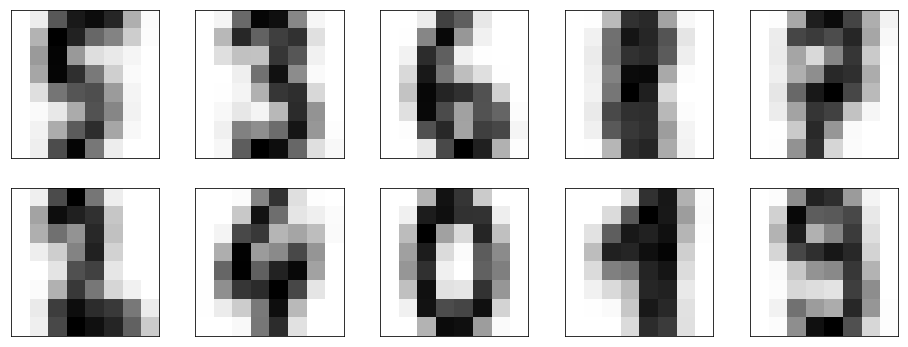

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6), subplot_kw={'xticks':[], 'yticks':[]})
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for ax, center in zip(axes.flat, centers):
    ax.imshow(center, cmap='binary')

One can make up some digits out of this.
It looks promising.
That said `kmeans` was never told what labels these digits,
it can only know that it should look for 10 different digits in the data.

In [7]:
clusters.shape, np.unique(clusters)

((1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32))

If we assume that the algorithm did most of its job right perhaps we can label these clusters.
In other words, we actually know the labels of these digits,
if we figure out the label that most often appear in a cluster we label the cluster with that label.

In [8]:
from scipy.stats import mode
label_map = {}
for i in range(10):
    label_map[i] = mode(digits.target[clusters == i])[0]
label_map

{0: array([5]),
 1: array([3]),
 2: array([6]),
 3: array([8]),
 4: array([7]),
 5: array([2]),
 6: array([4]),
 7: array([0]),
 8: array([1]),
 9: array([9])}

Mostly right.
Now we can build an array of what `kmeans` placed in what bag,
this will spit out something that can be scored in a similar way to a supervised algorithm.

In [9]:
labels = np.zeros_like(clusters)
for k, v in label_map.items():
    labels[clusters == k] = v
labels.shape

(1797,)

Default `kmeans` scoring is by **cluster inertia**,
the sum of all distances form points to its cluster center.
This allows to compare two `kmeans` runs against each other.
Notably, `sklearn` performs `kmeans` several times and then compares the inertia.
But this is not a good measure to compare `kmeans` between datasets or against other models.

Evaluating unsupervised algorithms between themselves is always a tricky area.
Here we knew the labels, therefore we can use supervised learning scoring,
e.g. F1 or weighted accuracy.

In [10]:
from sklearn.metrics import accuracy_score, f1_score
accuracy_score(digits.target, labels), f1_score(digits.target, labels, average='weighted')

(0.79187534780189206, 0.78897496803593192)

For an algorithm that only knew that there are 10 digits in the data but had
no idea how they look like that is a pretty amazing score.
Let's look at what got misclassified the most.

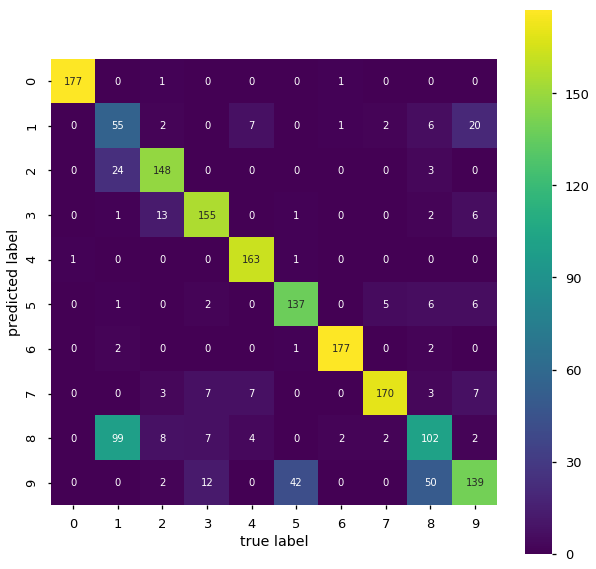

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(digits.target, labels)
fig = plt.figure(figsize=(10, 10))
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='viridis',
                 xticklabels=digits.target_names, yticklabels=digits.target_names)
ax.set(xlabel='true label', ylabel='predicted label');

## Extra: Distance Measures

We have only dealt with *euclidean distances* but that is not the only distance measure available.
In machine learning algorithm and in literature you will often find mention of *L-norms*.
An *L-norm* (also called $L^p$ space) often written as L1, L2, $\|\cdot\|_1$ or $\|\cdot\|_2$
is a notation of a specific measure of distance.
The most important one being L2 ($\|\cdot\|_2$), the euclidean distance.
The L-norm is defined, for a vector of $i$ components, as:

$$\|x\|_k = \left( \sum_{i=0}^{N} \lvert x_i \rvert ^k \right)^{\frac{1}{k}}$$

Therefore $\|x\|_2$ (or L2) is our well known

$$\|x\|_2 = \sqrt{\sum_{i=0}^{N} x_i^2}$$

The sum of absolutes, or $\|x\|_1$ (or L1) turns to be resistant against outliers,
and is sometimes preferred as a distance measure

$$\|x\|_1 = \sum_{i=0}^{N} \lvert x_i \rvert$$

L1 is also often called Manhattan distance due to the square shaped blocks in America.